In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pytorch3d.ops import sample_farthest_points

In [2]:
folder_path = "samples_data" # locazione della cartella in cui risiedono i campioni del Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
epochs = 100
lr = 0.001 # learning rate
train_ratio = 0.75 # percentuale campioni del Dataset che faranno parte del training set
num_layers = 2 # n° layer della GRU
hidden_size= 128 # n° features degli hidden state dei layer della GRU 
input_size = 2 # n° coordinate dei punti della traiettoria in input alla GRU (non si considera la y)
past_seconds = 2 # n° secondi che si considerano della traiettoria passata
future_seconds = 4 # n° secondi che si considerano della traiettoria futura
framerate = 10 # n° punti delle traiettorie campionati in un secondo

## Calcolo e salvataggio subsampling delle nuvole di punti

In [4]:
def extract_number(filename):
    return int(filename.split('_')[1].split('.')[0])

In [ ]:
all_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]        
npz_files = sorted(all_files, key=extract_number)

point_clouds_subsampled = [] # lista delle nuvole di punti sottocampionate

with torch.no_grad():
    for file_name in npz_files:
        file_path = os.path.join(folder_path, file_name)
        data = np.load(file_path)

        # Prende la nuvola di punti e la mette su GPU
        point_cloud = torch.tensor(data["point_cloud"], dtype=torch.float32).unsqueeze(0).to(device)

        # Calcola la nuvola di punti sottocampionata
        sampled_pc = sample_farthest_points(point_cloud, K=1024)[0].squeeze(0).cpu().numpy()

        # Aggiunge la nuvola sottocampionata alla lista
        point_clouds_subsampled.append(sampled_pc)

# Salva le nuvole sottocampionate in un file NPZ
np.savez_compressed("point_clouds_subsampled.npz", subsampling=np.array(point_clouds_subsampled))

print("Subsampled point clouds saved in 'point_clouds_subsampled.npz'!")

Subsampled point clouds saved in 'point_clouds_subsampled.npz'!


## Sezione addestramento del modello

In [3]:
class PointNetfeat(nn.Module):
    def __init__(self):
        super(PointNetfeat, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        return x

In [4]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, point_clouds_subsampled, past_seconds=2, future_seconds=4, framerate=10,
                  train_ratio=0.75, mode='all'):
        self.folder_path = folder_path
        self.past_frames = framerate * past_seconds
        self.future_frames = framerate * future_seconds
        self.point_clouds_subsampled = point_clouds_subsampled
        self.train_ratio = train_ratio
        self.mode = mode

        def extract_number(filename):
            return int(filename.split('_')[1].split('.')[0]) 

        all_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]
        all_files_sorted = sorted(all_files, key=extract_number)

        split_index = int(len(all_files_sorted) * train_ratio) # indice di separazione tra training e test set

        if mode == "train":
            self.npz_files = all_files_sorted[:split_index]
            self.point_clouds_subsampled = point_clouds_subsampled[:split_index]
        elif mode == "test":
            self.npz_files = all_files_sorted[split_index:]
            self.point_clouds_subsampled = point_clouds_subsampled[split_index:]
        else:
            self.npz_files = all_files_sorted
            self.point_clouds_subsampled = point_clouds_subsampled

    def __len__(self):
        return len(self.npz_files)

    def local_smoothing(self, future_traj, iterations=1): # funzione che esegue lo smoothing locale
                                                          # della traiettoria futura
        smoothed_traj = future_traj.clone()

        for _ in range(iterations):
            temp_traj = smoothed_traj.clone()

            prev_points = temp_traj[:-2]
            current_points = temp_traj[1:-1]
            next_points = temp_traj[2:]

            smoothed_traj[1:-1] = 0.25*prev_points + 0.5*current_points + 0.25*next_points   
        
        return smoothed_traj

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.npz_files[idx])
        data = np.load(file_path)

        # Converte le traiettorie (senza la coordinata y) e la nuvola in tensori PyTorch
        past_trajectory = torch.tensor(np.delete(data["past_trajectory"], 1, 1), dtype=torch.float32)
        future_trajectory = torch.tensor(np.delete(data["future_trajectory"], 1, 1), dtype=torch.float32)
        point_clouds_subsampled = (self.point_clouds_subsampled[idx])

        past_trajectory = past_trajectory[:self.past_frames]
        future_trajectory = future_trajectory[:self.future_frames]

        past_trajectory = torch.flip(past_trajectory, [0]) # Inverte la traiettoria passata in modo che
                                                           # inizi dal punto più lontano nel tempo e termini
                                                           # con quello presente (0, 0)

        if(self.mode == "train"): # Data Augmentation
            if(np.random.rand() < 0.5):
                # smoothing locale della traiettoria futura
                n_iterations = np.random.randint(1, 3)
                future_trajectory = self.local_smoothing(future_trajectory, iterations=n_iterations)

            if np.random.rand() < 0.5:
                # flip orizzontale di tutta la traiettoria e dei punti della nuvola
                past_trajectory[:, 0] *= -1
                future_trajectory[:, 0] *= -1
                point_clouds_subsampled[:, 0] *= -1    


        return past_trajectory, future_trajectory, point_clouds_subsampled

In [5]:
class AutoregressiveModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, output_size=2, num_layers=2, future_steps=40):
        super(AutoregressiveModel, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.future_steps = future_steps
        
        self.pointnet = PointNetfeat()
        self.pc_emb_proj = nn.Linear(1024, self.hidden_size)
        self.pc_emb_norm = nn.LayerNorm(self.hidden_size)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, pc):
        pc = pc.to(x.device)
        pc_emb = self.pointnet(pc)
        pc_emb = self.pc_emb_norm(self.pc_emb_proj(pc_emb))

        h0 = pc_emb.unsqueeze(0).repeat(self.num_layers, 1, 1).to(x.device)
        
        out, h = self.gru(x[:, :-1, :], h0) # out contiene tutti gli hidden state (dell'ultimo layer della GRU) 
                                            # di tutta la sequenza (ultimo punto escluso) ed ha quindi dimensione 
                                            # [batch_size, seq_length-1, hidden_dim]
                                            # h contiene l'ultimo hidden state della sequenza di ogni layer della 
                                            # GRU, ed ha dimensione [num_layers, batch_size, hidden_dim]
        
        future_trajectory_pred = []
        last_input = x[:, -1, :]  # ultimo punto della traiettoria passata ([batch_size, input_size])

        for _ in range(self.future_steps): 
            last_input = last_input.unsqueeze(1) #la dimensione ora è [batch_size, 1, input_size]
            out, h = self.gru(last_input, h)
            future_point = self.fc(out.squeeze(1)) # predizione punto successivo
            future_trajectory_pred.append(future_point)
            last_input = future_point # il punto successivo predetto diventa l'ultimo input
             
        return torch.stack(future_trajectory_pred, dim=1)

In [6]:
class OneShotModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, output_size=2*40, num_layers=2, future_steps=40):
        super(OneShotModel, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.future_steps = future_steps
        
        self.pointnet = PointNetfeat()
        self.pc_emb_proj = nn.Linear(1024, self.hidden_size)
        self.pc_emb_norm = nn.LayerNorm(self.hidden_size)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, pc):
        pc = pc.to(x.device)
        pc_emb = self.pointnet(pc)
        pc_emb = self.pc_emb_norm(self.pc_emb_proj(pc_emb))

        h0 = pc_emb.unsqueeze(0).repeat(self.num_layers, 1, 1).to(x.device)
        
        _, h = self.gru(x, h0) # out contiene tutti gli hidden state (dell'ultimo layer della GRU) di tutta la 
                               # sequenza ed ha quindi dimensione [batch_size, seq_length, hidden_dim]
                               # h contiene l'ultimo hidden state della sequenza di ogni layer della GRU, ed ha 
                               # dimensione [num_layers, batch_size, hidden_dim]
        
        last_hidden = h[-1]  # [batch_size, hidden_size]
        future_points = self.fc(last_hidden)  # [batch_size, 2*future_steps]
        future_points = future_points.view(x.size(0), self.future_steps, self.input_size)
             
        return future_points

In [7]:
def train(model, device, train_loader, optimizer, future_x_std, future_z_std):
    model.train() # setta il modello in training mode
    
    lambda_x = 1./future_x_std
    lambda_z = 1./future_z_std
    
    train_mse_x = 0
    train_mse_z = 0
    train_mse_total = 0
    total_samples = 0

    for past, future, pc in train_loader: # iterazione sui batch
        past, future = past.to(device), future.to(device) #spostamento traiettoria passata e futura sulla GPU
        optimizer.zero_grad() #azzera i gradienti

        future_pred = model(past, pc) #viene eseguito il forward

        #calcolo delle loss, con la somma per normalizzare
        loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum') # MSE su x
        loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum') # MSE su z
        loss_total = lambda_x * loss_x + lambda_z * loss_z   
        
        train_mse_x += loss_x.item()
        train_mse_z += loss_z.item()
        train_mse_total += loss_total.item()

        loss_total.backward() # calcola i gradienti
        optimizer.step() # aggiorna i pesi

        total_samples += future.size(0) * future.size(1)  # numero totale di punti della traiettoria

    # normalizzazione per ottenere la media
    train_mse_x /= total_samples
    train_mse_z /= total_samples
    train_mse_total /= total_samples

    print(f'Train: MSE Total = {train_mse_total:.6f},  MSE X = {train_mse_x:.6f},  MSE Z = {train_mse_z:.6f}')
    
    return train_mse_total, train_mse_x, train_mse_z

In [8]:
def test(model, device, test_loader, future_x_std, future_z_std):
    model.eval() #setta il modello in evaluation mode
    
    lambda_x = 1./future_x_std
    lambda_z = 1./future_z_std
    
    test_mse_x, test_mse_z, test_mse_total = 0, 0, 0
    total_samples = 0

    with torch.no_grad():
        for past, future, pc in test_loader:
            past, future = past.to(device), future.to(device)
            future_pred = model(past, pc)

            loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum')  # MSE su x
            loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum')  # MSE su z
            loss_total = lambda_x * loss_x + lambda_z * loss_z  
            
            test_mse_x += loss_x.item()
            test_mse_z += loss_z.item()
            test_mse_total += loss_total.item()

            total_samples += future.size(0) * future.size(1)

    # normalizzazione per ottenere la media
    test_mse_x /= total_samples
    test_mse_z /= total_samples
    test_mse_total /= total_samples

    print(f'Test:  MSE Total = {test_mse_total:.6f},  MSE X = {test_mse_x:.6f},  MSE Z = {test_mse_z:.6f}')
    return test_mse_total, test_mse_x, test_mse_z

In [9]:
def fit(model, device, train_loader, test_loader, optimizer, epochs, future_x_std, future_z_std):

    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_test_loss = float("inf")

    train_losses_x = []
    train_losses_z = []
    train_losses_total = []
    test_losses_x = []
    test_losses_z = []
    test_losses_total = []

    start_time = time.time()

    for epoch in range(1, epochs + 1):
        #esegue un'epoca di training
        print(f"Epoch {epoch}")
        train_loss_total, train_loss_x, train_loss_z = train(model, device, train_loader, optimizer,
                                                            future_x_std, future_z_std)
        test_loss_total, test_loss_x, test_loss_z = test(model, device, test_loader, future_x_std, future_z_std)

        if(test_loss_total < best_test_loss):
            best_epoch = epoch
            best_test_loss = test_loss_total
            best_weights = copy.deepcopy(model.state_dict()) 

        train_losses_total.append(train_loss_total)
        train_losses_x.append(train_loss_x)
        train_losses_z.append(train_loss_z)
        test_losses_total.append(test_loss_total)
        test_losses_x.append(test_loss_x)
        test_losses_z.append(test_loss_z)
        print()

    model.load_state_dict(best_weights)
    print(f"Got the weights of the epoch {best_epoch}")

    end_time = time.time()

    execution_time = end_time - start_time

    minutes, seconds = divmod(execution_time, 60) #converte il tempo in minuti e secondi

    print(f"Execution time: {int(minutes)} minutes, {seconds:.2f} seconds")

    return {
        "train_losses": {
            "total": train_losses_total,
            "x": train_losses_x,
            "z": train_losses_z
        },
        "test_losses": {
            "total": test_losses_total,
            "x": test_losses_x,
            "z": test_losses_z
        }
    }

In [10]:
def plot_loss(epochs, history):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 riga, 3 colonne

    # Plot per la loss totale
    axes[0].plot(range(1, epochs + 1), history["train_losses"]["total"], marker='o', color='red', label="Train Total loss")
    axes[0].plot(range(1, epochs + 1), history["test_losses"]["total"], marker='o', color='blue', label="Test Total loss")
    axes[0].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Total Loss')

    # Plot per la loss su X
    axes[1].plot(range(1, epochs + 1), history["train_losses"]["x"], marker='o', color='red', label="Train X loss")
    axes[1].plot(range(1, epochs + 1), history["test_losses"]["x"], marker='o', color='blue', label="Test X loss")
    axes[1].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].set_title('X Loss')

    # Plot per la loss su Z
    axes[2].plot(range(1, epochs + 1), history["train_losses"]["z"], marker='o', color='red', label="Train Z loss")
    axes[2].plot(range(1, epochs + 1), history["test_losses"]["z"], marker='o', color='blue', label="Test Z loss")
    axes[2].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].set_title('Z Loss')

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()

In [11]:
# Carica le nuvole di punti sottocampionate e crea un lista contenente i rispettivi tensori
loaded_pc_subsampled = np.load("point_clouds_subsampled.npz")
point_clouds_subsampled = [torch.tensor(subsampling, dtype=torch.float32) for subsampling in 
                           loaded_pc_subsampled["subsampling"]]


# Istanziamento del Dataset completo e del training e test set con i rispettivi DataLoader

original_dataset = CustomDataset(folder_path=folder_path, point_clouds_subsampled=point_clouds_subsampled, 
                        past_seconds=past_seconds, future_seconds=future_seconds, framerate=framerate, mode="all")

train_set = CustomDataset(folder_path=folder_path, point_clouds_subsampled=point_clouds_subsampled, 
                        past_seconds=past_seconds, future_seconds=future_seconds, framerate=framerate, 
                        train_ratio=train_ratio, mode="train")

test_set = CustomDataset(folder_path=folder_path, point_clouds_subsampled=point_clouds_subsampled, 
                        past_seconds=past_seconds, future_seconds=future_seconds, framerate=framerate, 
                        train_ratio=train_ratio, mode="test")

train_loader = DataLoader(train_set, num_workers=2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, num_workers=2, batch_size=batch_size, shuffle=False)


In [12]:
for past, future, pc in train_loader:
    print(past.shape)
    print(future.shape)
    print(pc.shape)
    break

torch.Size([64, 20, 2])
torch.Size([64, 40, 2])
torch.Size([64, 1024, 3])


In [12]:
#Calcolo della varianza e della deviazione standard globali di x e di z nel futuro

all_x_values = []
all_z_values = []

for past, future, _ in original_dataset:
    all_x_values.append(future[:, 0])
    all_z_values.append(future[:, 1])

#Concatenazione di tutti i punti
all_x_values = torch.cat(all_x_values)
all_z_values = torch.cat(all_z_values)

future_x_var = torch.var(all_x_values)
future_z_var = torch.var(all_z_values)

future_x_std = future_x_var ** 0.5
future_z_std = future_z_var ** 0.5

print(f"Global variance of the future x-coordinate: {future_x_var.item()}")
print(f"Global variance of the future z-coordinate: {future_z_var.item()}")

Global variance of the future x-coordinate: 0.5222423076629639
Global variance of the future z-coordinate: 2.0641021728515625


In [ ]:
batch = next(iter(test_loader))  # Prende un batch dal test_loader
past_batch, future_batch, _ = batch

for points in past_batch:
    print(points.shape)
    print(points[0])


for i in range(2):  # Plotta solo 2 esempi
    past = past_batch[i].numpy()
    future = future_batch[i].numpy()

    plt.figure(figsize=(5, 5))
    plt.plot(past[:, 0], past[:, 1], 'go-', label='Past Trajectory')
    plt.plot(future[:, 0], future[:, 1], 'ro-', label='Future Trajectory')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.legend()
    plt.title(f"Sample {i+1}")
    plt.show()

In [14]:
# Istanziamento e fitting del modello autoregressivo

autoregressive_model = AutoregressiveModel(input_size=input_size, hidden_size=hidden_size, 
                                           output_size=input_size, num_layers=num_layers, 
                                           future_steps=future_seconds*framerate).to(device)

autoregressive_optimizer = optim.Adam(autoregressive_model.parameters(), lr=lr, weight_decay=1e-5)

print("Fitting autoregressive model:\n")
autoregressive_history = fit(autoregressive_model, device, train_loader, test_loader, 
                             autoregressive_optimizer, epochs, future_x_std, future_z_std)

Fitting autoregressive model:

Epoch 1
Train: MSE Total = 1.896424,  MSE X = 0.570414,  MSE Z = 1.590572
Test:  MSE Total = 0.890460,  MSE X = 0.450528,  MSE Z = 0.383645

Epoch 2
Train: MSE Total = 0.983029,  MSE X = 0.556357,  MSE Z = 0.306245
Test:  MSE Total = 0.756627,  MSE X = 0.445946,  MSE Z = 0.200477

Epoch 3
Train: MSE Total = 0.925481,  MSE X = 0.556769,  MSE Z = 0.222747
Test:  MSE Total = 0.890993,  MSE X = 0.445894,  MSE Z = 0.393625

Epoch 4
Train: MSE Total = 0.925333,  MSE X = 0.554921,  MSE Z = 0.226209
Test:  MSE Total = 0.725250,  MSE X = 0.444691,  MSE Z = 0.157894

Epoch 5
Train: MSE Total = 0.902355,  MSE X = 0.555344,  MSE Z = 0.192355
Test:  MSE Total = 0.734357,  MSE X = 0.446188,  MSE Z = 0.168000

Epoch 6
Train: MSE Total = 0.899613,  MSE X = 0.555493,  MSE Z = 0.188119
Test:  MSE Total = 0.732709,  MSE X = 0.452332,  MSE Z = 0.153419

Epoch 7
Train: MSE Total = 0.905599,  MSE X = 0.557029,  MSE Z = 0.193665
Test:  MSE Total = 0.721090,  MSE X = 0.442516,  

Autoregressive model losses:


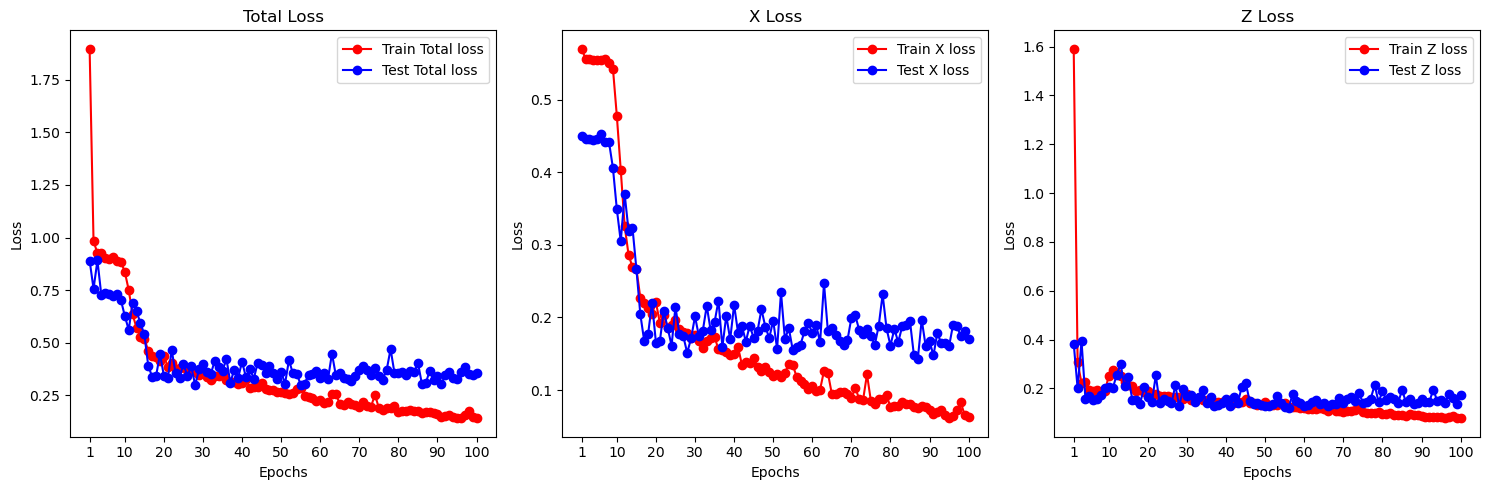

In [15]:
# Plot delle loss del modello autoregressivo

print("Autoregressive model losses:")
plot_loss(epochs, autoregressive_history)

In [17]:
# Salvataggio pesi del modello autoregressivo

torch.save(autoregressive_model.state_dict(), "pred_from_past_and_pc_geom_autoreg_model")
print("Autoregressive model weights saved in 'pred_from_past_and_pc_geom_autoreg_model'!")

Autoregressive model weights saved in 'pred_from_past_and_pc_geom_autoreg_model'!


In [17]:
# Istanziamento e fitting del modello one shot

one_shot_model = OneShotModel(input_size=input_size, hidden_size=hidden_size, 
                              output_size=input_size*future_seconds*framerate, num_layers=num_layers, 
                              future_steps=future_seconds*framerate).to(device)

one_shot_optimizer = optim.Adam(one_shot_model.parameters(), lr=lr, weight_decay=1e-5)

print("Fitting one shot model:\n")
one_shot_history = fit(one_shot_model, device, train_loader, test_loader, one_shot_optimizer, epochs, 
                       future_x_std, future_z_std)

Fitting one shot model:

Epoch 1
Train: MSE Total = 1.989897,  MSE X = 0.567581,  MSE Z = 1.730496
Test:  MSE Total = 0.760841,  MSE X = 0.444801,  MSE Z = 0.208806

Epoch 2
Train: MSE Total = 0.859460,  MSE X = 0.498741,  MSE Z = 0.243257
Test:  MSE Total = 0.715956,  MSE X = 0.420517,  MSE Z = 0.192600

Epoch 3
Train: MSE Total = 0.656587,  MSE X = 0.354105,  MSE Z = 0.239336
Test:  MSE Total = 0.407618,  MSE X = 0.205939,  MSE Z = 0.176205

Epoch 4
Train: MSE Total = 0.509188,  MSE X = 0.260091,  MSE Z = 0.214472
Test:  MSE Total = 0.382772,  MSE X = 0.196523,  MSE Z = 0.159229

Epoch 5
Train: MSE Total = 0.456063,  MSE X = 0.231562,  MSE Z = 0.194865
Test:  MSE Total = 0.458743,  MSE X = 0.227735,  MSE Z = 0.206325

Epoch 6
Train: MSE Total = 0.438591,  MSE X = 0.225505,  MSE Z = 0.181806
Test:  MSE Total = 0.349412,  MSE X = 0.165559,  MSE Z = 0.172858

Epoch 7
Train: MSE Total = 0.409462,  MSE X = 0.207761,  MSE Z = 0.175232
Test:  MSE Total = 0.327929,  MSE X = 0.163866,  MSE Z 

One shot model losses:


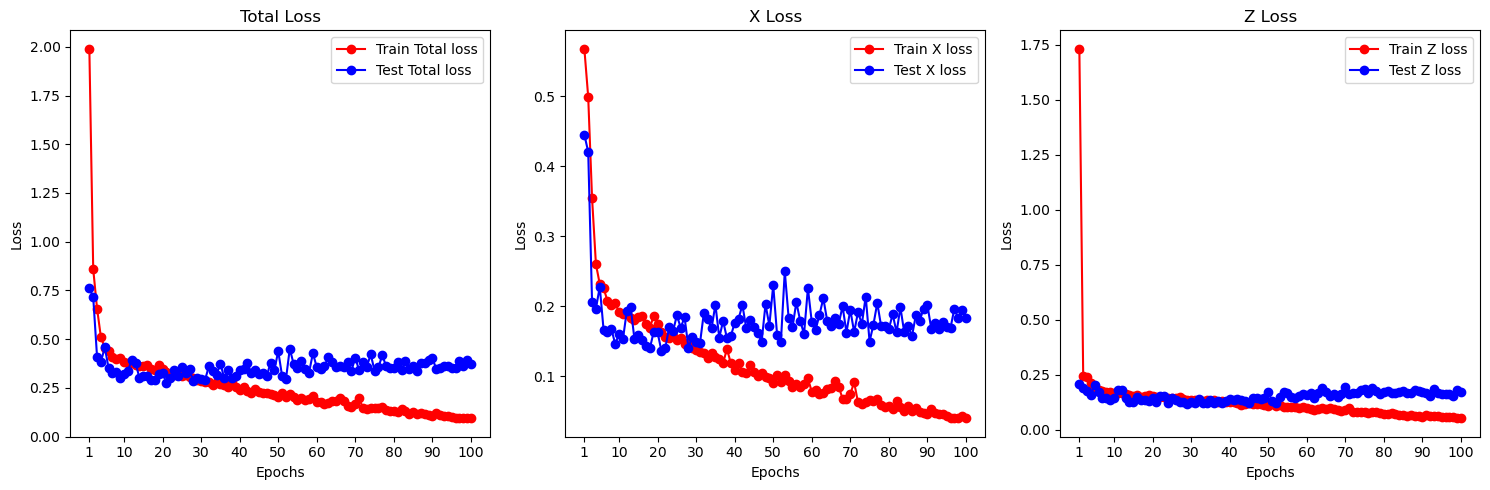

In [18]:
# Plot delle loss del modello one shot

print("One shot model losses:")
plot_loss(epochs, one_shot_history)

In [18]:
# Salvataggio pesi del modello one shot

torch.save(one_shot_model.state_dict(), "pred_from_past_and_pc_geom_oneshot_model")
print("One shot model weights saved in 'pred_from_past_and_pc_geom_oneshot_model'!")

One shot model weights saved in 'pred_from_past_and_pc_geom_oneshot_model'!


## Evaluation

In [20]:
# Funzione che seleziona alcune traiettorie dal test set e le plott­a insieme alle traiettorie future predette
# dal modello

def evaluate_trajectories(model, device, test_loader):

    model.eval()

    examples = []
    batch_indices = 6   # numero batch consecutivi usati
    example_index = [9, 9, 9, 0, 5, 50]

    # Itera sui primi 6 batch del test_loader
    for b_idx, batch in enumerate(test_loader):
        if b_idx >= batch_indices:
            break

        past_batch, future_batch, pc_batch = batch
        
        examples.append((past_batch[example_index[b_idx]], future_batch[example_index[b_idx]], 
                         pc_batch[example_index[b_idx]]))

    examples[3], examples[4], examples[5] = examples[4], examples[5], examples[3]    

    _, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, (past, future, pc) in enumerate(examples):
        
        all_points = torch.cat((past, future), 0)
        past_np = past.cpu().numpy()
        future_np = future.cpu().numpy()

        # Predizione del modello
        past_tensor = past.unsqueeze(0).to(device)  # prende un campione e aggiunge batch dim
        pc_tensor = pc.unsqueeze(0).to(device)
        with torch.no_grad():
            predicted_future = model(past_tensor, pc_tensor).squeeze(0).cpu().detach().numpy() # predice e 
                                                                                               # converte in numpy

        row, col = divmod(i, 3)  # Converte i in (riga, colonna)

        # Plot
        axes[row, col].plot(past_np[:, 0], past_np[:, 1], 'g-o', label="Past Trajectory") 
        axes[row, col].plot(future_np[:, 0], future_np[:, 1], 'r-o', label="Real Future Trajectory") 
        axes[row, col].plot(predicted_future[:, 0], predicted_future[:, 1], 'm-o', label="Predicted Future Trajectory")
        
        axes[row, col].set_xlabel("X")
        axes[row, col].set_ylabel("Z")
        axes[row, col].set_title(f"Case {i+1}")
        axes[row, col].legend()
        axes[row, col].grid()

        x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
        z_min, z_max = all_points[:, 1].min(), all_points[:, 1].max()
        
        x_min_tick = float(np.floor(float(x_min)))
        x_max_tick = float(np.ceil(float(x_max)))
        z_min_tick = float(np.floor(float(z_min)))
        z_max_tick = float(np.ceil(float(z_max)))

        axes[row, col].set_xticks(np.arange(x_min_tick, x_max_tick + 0.5, 0.5))
        axes[row, col].set_yticks(np.arange(z_min_tick, z_max_tick + 1.0, 1.0))

    plt.tight_layout()
    plt.show()

In [21]:
# Funzione che calcola e printa ADE e FDE del modello sul train e sul test set

def performance_measurement(model, device, train_loader, test_loader, label=''):
    model.eval() #setta il modello in evaluation mode
    
    train_ade_x, train_ade_z, train_ade_total = 0, 0, 0
    train_fde_x, train_fde_z, train_fde_total = 0, 0, 0
    test_ade_x, test_ade_z, test_ade_total = 0, 0, 0
    test_fde_x, test_fde_z, test_fde_total = 0, 0, 0
    total_samples = 0

    # Misurazione performance sul train set

    with torch.no_grad():
        for past, future, pc in train_loader:
            past, future = past.to(device), future.to(device)
            future_pred = model(past, pc)

            ade_x = torch.abs(future_pred[:, :, 0] - future[:, :, 0]).sum()
            ade_z = torch.abs(future_pred[:, :, -1] - future[:, :, -1]).sum()
            ade_total = torch.norm(future_pred - future, dim=2).sum()

            fde_x = torch.abs(future_pred[:, -1, 0] - future[:, -1, 0]).sum()
            fde_z = torch.abs(future_pred[:, -1, -1] - future[:, -1, -1]).sum()
            fde_total = torch.norm(future_pred[:, -1, :] - future[:, -1, :], dim=1).sum()
            
            train_ade_x += ade_x.item()
            train_ade_z += ade_z.item()
            train_ade_total += ade_total.item()

            train_fde_x += fde_x.item()
            train_fde_z += fde_z.item()
            train_fde_total += fde_total.item()

            total_samples += future.size(0) * future.size(1)

    train_ade_x /= total_samples
    train_ade_z /= total_samples
    train_ade_total /= total_samples

    train_fde_x /= len(train_loader.dataset)
    train_fde_z /= len(train_loader.dataset)
    train_fde_total /= len(train_loader.dataset)

    print(f'{label} model performances on train set:')
    print(f'\nADE Total = {train_ade_total:.6f},   ADE X = {train_ade_x:.6f},   ADE Z = {train_ade_z:.6f}')
    print(f'FDE Total = {train_fde_total:.6f},   FDE X = {train_fde_x:.6f},   FDE Z = {train_fde_z:.6f}')

    
    # Misurazione performance sul test set

    total_samples = 0

    with torch.no_grad():
        for past, future, pc in test_loader:
            past, future = past.to(device), future.to(device)
            future_pred = model(past, pc)

            ade_x = torch.abs(future_pred[:, :, 0] - future[:, :, 0]).sum()
            ade_z = torch.abs(future_pred[:, :, -1] - future[:, :, -1]).sum()
            ade_total = torch.norm(future_pred - future, dim=2).sum()

            fde_x = torch.abs(future_pred[:, -1, 0] - future[:, -1, 0]).sum()
            fde_z = torch.abs(future_pred[:, -1, -1] - future[:, -1, -1]).sum()
            fde_total = torch.norm(future_pred[:, -1, :] - future[:, -1, :], dim=1).sum()
            
            test_ade_x += ade_x.item()
            test_ade_z += ade_z.item()
            test_ade_total += ade_total.item()

            test_fde_x += fde_x.item()
            test_fde_z += fde_z.item()
            test_fde_total += fde_total.item()

            total_samples += future.size(0) * future.size(1)

    test_ade_x /= total_samples
    test_ade_z /= total_samples
    test_ade_total /= total_samples

    test_fde_x /= len(test_loader.dataset)
    test_fde_z /= len(test_loader.dataset)
    test_fde_total /= len(test_loader.dataset)

    print(f'\n{label} model performances on test set:')
    print(f'\nADE Total = {test_ade_total:.6f},   ADE X = {test_ade_x:.6f},   ADE Z = {test_ade_z:.6f}')
    print(f'FDE Total = {test_fde_total:.6f},   FDE X = {test_fde_x:.6f},   FDE Z = {test_fde_z:.6f}')

In [13]:
# Istanzia il modello autoregressivo e ne carica i pesi

autoregressive_model = AutoregressiveModel(input_size=input_size, hidden_size=hidden_size, 
                            output_size=input_size, num_layers=num_layers, 
                            future_steps=future_seconds*framerate).to(device)

autoregressive_model.load_state_dict(torch.load("pred_from_past_and_pc_geom_autoreg_model"))

autoregressive_model.eval()

AutoregressiveModel(
  (pointnet): PointNetfeat(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pc_emb_proj): Linear(in_features=1024, out_features=128, bias=True)
  (pc_emb_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (gru): GRU(2, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Evaluating autoregressive model trajectories:


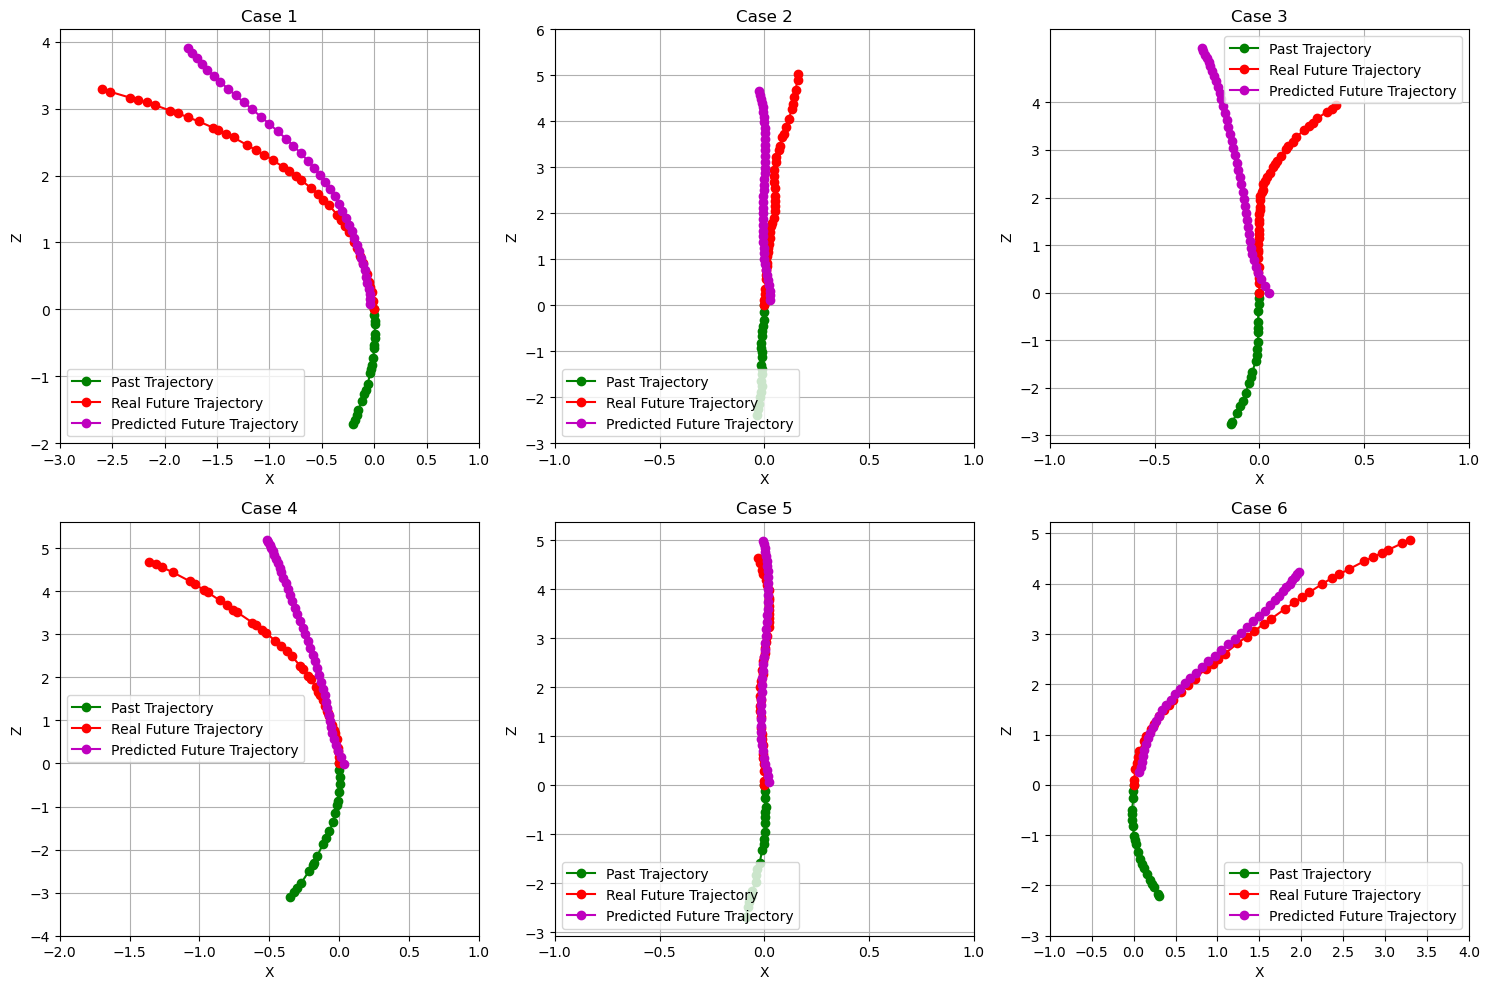

Autoregressive model performances on train set:

ADE Total = 0.427022,   ADE X = 0.236665,   ADE Z = 0.305731
FDE Total = 0.913036,   FDE X = 0.632566,   FDE Z = 0.543130

Autoregressive model performances on test set:

ADE Total = 0.388991,   ADE X = 0.235415,   ADE Z = 0.260713
FDE Total = 0.867274,   FDE X = 0.636929,   FDE Z = 0.474974


In [23]:
# Evaluation del modello autoregressivo (plot traiettorie + calcolo metriche)

print("Evaluating autoregressive model trajectories:")
evaluate_trajectories(autoregressive_model, device, test_loader)

performance_measurement(autoregressive_model, device, train_loader, test_loader, label="Autoregressive")

In [14]:
# Istanzia il modello one shot e ne carica i pesi

one_shot_model = OneShotModel(input_size=input_size, hidden_size=hidden_size, 
                              output_size=input_size*future_seconds*framerate, num_layers=num_layers, 
                              future_steps=future_seconds*framerate).to(device)

one_shot_model.load_state_dict(torch.load("pred_from_past_and_pc_geom_oneshot_model"))

one_shot_model.eval()

OneShotModel(
  (pointnet): PointNetfeat(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pc_emb_proj): Linear(in_features=1024, out_features=128, bias=True)
  (pc_emb_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (gru): GRU(2, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=80, bias=True)
)

Evaluating one shot model trajectories:


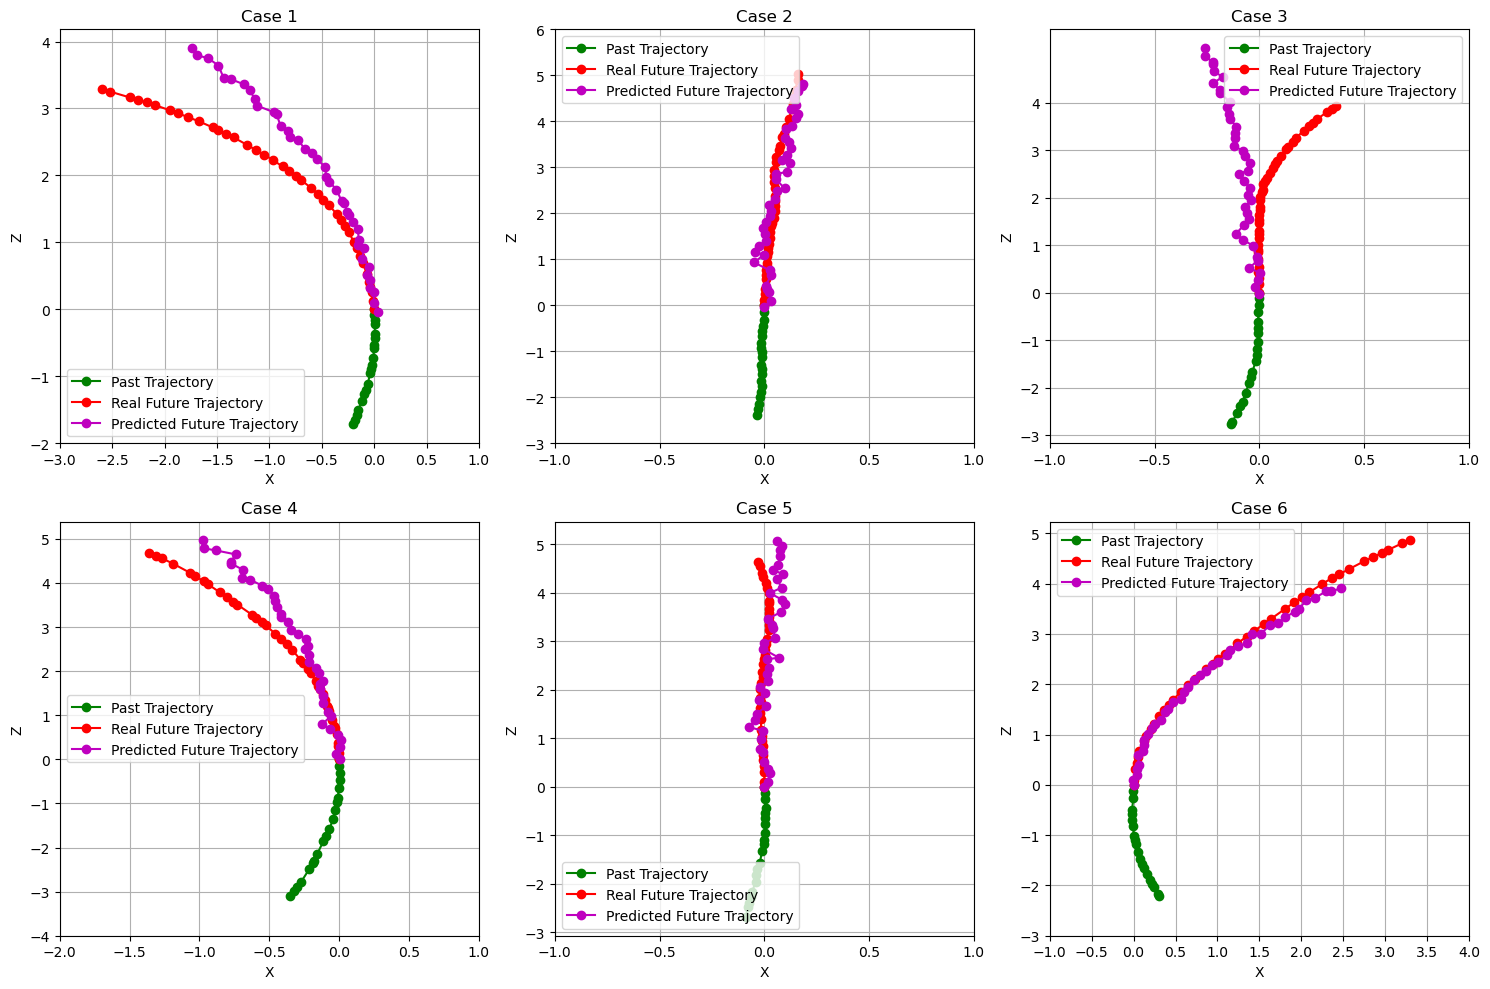

One shot model performances on train set:

ADE Total = 0.385189,   ADE X = 0.234076,   ADE Z = 0.253912
FDE Total = 0.865675,   FDE X = 0.606897,   FDE Z = 0.497828

One shot model performances on test set:

ADE Total = 0.366299,   ADE X = 0.220494,   ADE Z = 0.246985
FDE Total = 0.837170,   FDE X = 0.576071,   FDE Z = 0.491083


In [25]:
# Evaluation del modello one shot (plot traiettorie + calcolo metriche)

print("Evaluating one shot model trajectories:")
evaluate_trajectories(one_shot_model, device, test_loader)

performance_measurement(one_shot_model, device, train_loader, test_loader, label="One shot")